# Import Package

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from pyro.nn import PyroModule

import pyro
import pyro.distributions as dist

# Load Dataset

In [4]:
data = pd.read_csv('rugged_data.csv', encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]     # 僅取"是否為非洲地區國家"、"地形崎嶇程度"及gdp三個欄位使用
df = df[np.isfinite(df.rgdppc_2000)]                    # 去除無效gdp的資料
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])           # 為方便後續處理，將gdp取log表示

# Define Model

In [15]:
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

linear_reg_model = PyroModule[nn.Linear](3, 1)

loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500

In [16]:
def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

# Training

In [17]:
for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

[iteration 0050] loss: 3414.4204
[iteration 0100] loss: 1871.5990
[iteration 0150] loss: 1276.9182
[iteration 0200] loss: 936.3673
[iteration 0250] loss: 697.6187
[iteration 0300] loss: 519.5940
[iteration 0350] loss: 389.9518
[iteration 0400] loss: 299.6307
[iteration 0450] loss: 239.4879
[iteration 0500] loss: 201.1488
[iteration 0550] loss: 177.7204
[iteration 0600] loss: 163.9837
[iteration 0650] loss: 156.2511
[iteration 0700] loss: 152.0708
[iteration 0750] loss: 149.9002
[iteration 0800] loss: 148.8176
[iteration 0850] loss: 148.2990
[iteration 0900] loss: 148.0605
[iteration 0950] loss: 147.9552
[iteration 1000] loss: 147.9107
[iteration 1050] loss: 147.8926
[iteration 1100] loss: 147.8855
[iteration 1150] loss: 147.8829
[iteration 1200] loss: 147.8820
[iteration 1250] loss: 147.8817
[iteration 1300] loss: 147.8816
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815


In [18]:
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

Learned parameters:
weight [[-1.9479567  -0.2028225   0.39335078]]
bias [9.223153]


# Show Result

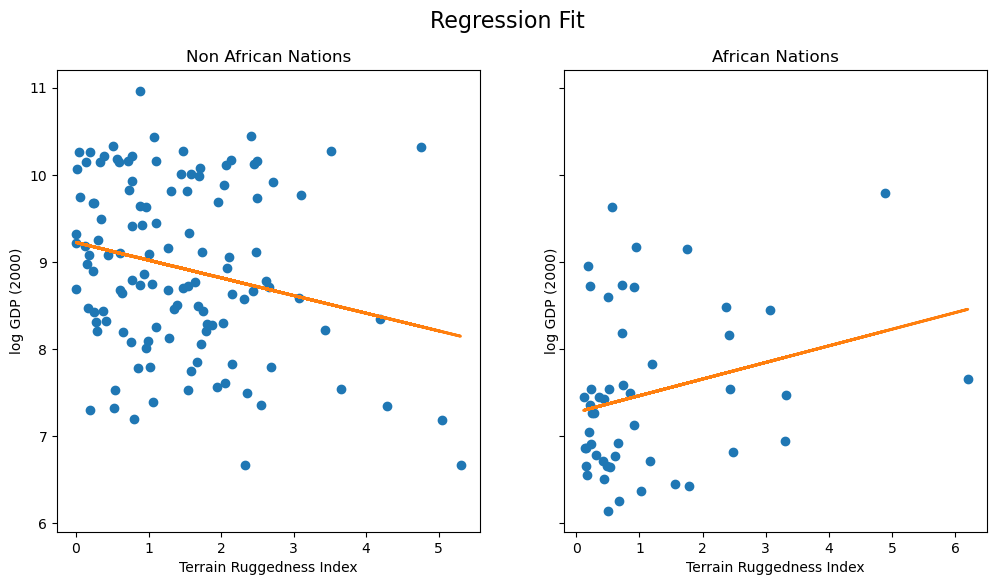

In [19]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()   

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

plt.show()